In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from scipy import misc
from warnings import filterwarnings
filterwarnings('ignore')

%matplotlib inline

%run 'DataImport.ipynb'

Using TensorFlow backend.


In [2]:
filepath = os.path.join('.','data')
datapath= filepath

In [3]:
data = DataSet(filepath,dataset_type='micro_2D', batch_size=32)

In [4]:
data.batch_size

32

In [5]:
data.num_batches

612

In [6]:
data.num_samples

19600

In [7]:
data.num_val_samples

8400

In [8]:
x_batch, y_batch = next(data.val_batches())
print(np.shape(y_batch))
y_back = []
for train in y_batch:
    y_back.append(train.argmax(1))

y_back = np.asarray(y_back)
y_back = y_back.reshape(x_batch.shape[0],x_batch.shape[1],x_batch.shape[2]) 
np.shape(y_back)

(32, 16384, 2)


(32, 128, 128)

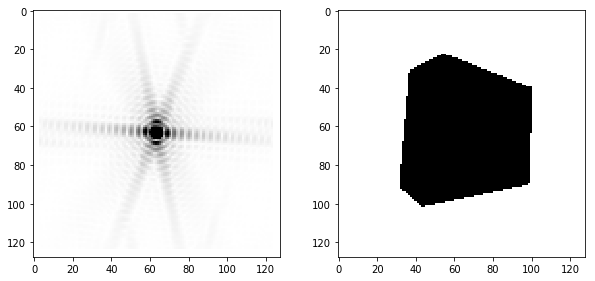

In [9]:
plt.figure(1,figsize=(10,10))
plt.subplot(221)
plt.imshow(x_batch[2].reshape(128,128), cmap='gist_gray')
plt.subplot(222, facecolor='y') 
plt.imshow(y_back[2].reshape(128,128), cmap='gist_gray')

### Create Model

In [10]:
from keras.layers import Input, Conv2D, Dropout, BatchNormalization, MaxPooling2D, Concatenate, UpSampling2D
from keras.layers import Reshape, Activation, Permute
from keras.models import Model
import keras
#from keras.optimizers import SGD

In [11]:
#sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=False)
def Unet(nClasses , optimizer='RMSprop' ,kernel_initializer='VarianceScaling', dropout = 0.2, input_width=360 , input_height=480 , nChannels=3 ): 
    
    inputs = Input((input_height, input_width, nChannels))
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer=kernel_initializer)(inputs)
    conv1 = Dropout(dropout)(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer=kernel_initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=kernel_initializer)(pool1)
    conv2 = Dropout(dropout)(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=kernel_initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=kernel_initializer)(pool2)
    conv3 = Dropout(dropout)(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same',kernel_initializer=kernel_initializer)(conv3)

    up1 = Concatenate(axis=-1)([UpSampling2D(size=(2, 2))(conv3), conv2])
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=kernel_initializer)(up1)
    conv4 = Dropout(dropout)(conv4)
    conv4 = Conv2D(64, (3, 3), activation='relu', padding='same',kernel_initializer=kernel_initializer)(conv4)
    
    up2 = Concatenate(axis=-1)([UpSampling2D(size=(2, 2))(conv4), conv1])
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer=kernel_initializer)(up2)
    conv5 = Dropout(dropout)(conv5)
    conv5 = Conv2D(32, (3, 3), activation='relu', padding='same',kernel_initializer=kernel_initializer)(conv5)
    
    conv6 = Conv2D(nClasses, (1, 1), activation='relu',padding='same',kernel_initializer=kernel_initializer)(conv5)
    conv6 = Reshape((nClasses,input_height*input_width))(conv6)
    conv6 = Permute((2,1))(conv6)


    conv7 = Activation('softmax')(conv6)

    model = Model(input=inputs, output=conv7)

    if not optimizer is None:
        model.compile(loss="categorical_crossentropy", optimizer= optimizer , metrics=['accuracy'] )
    return model

In [17]:
input_height, input_width, nChannels = np.shape(x_batch)[1], np.shape(x_batch)[2], np.shape(x_batch)[3]

UNet = Unet(2,input_width=input_width , input_height=input_height , nChannels=nChannels)
UNet.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv2d_12 (Conv2D)               (None, 128, 128, 32)  320         input_2[0][0]                    
____________________________________________________________________________________________________
dropout_6 (Dropout)              (None, 128, 128, 32)  0           conv2d_12[0][0]                  
____________________________________________________________________________________________________
conv2d_13 (Conv2D)               (None, 128, 128, 32)  9248        dropout_6[0][0]                  
___________________________________________________________________________________________

In [307]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
filepath = './UNet.h5'

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

modl_checkpoint = ModelCheckpoint(filepath, monitor = 'val_loss', verbose = 0,
                                     save_best_only = True, mode = 'min', period = 2)

hist = LossHistory()

callbacks = [hist, modl_checkpoint] 

In [18]:
UNet.load_weights(filepath)

OSError: Unable to open file (file read failed: time = Wed Feb 14 12:36:14 2018
, filename = './data', file descriptor = 58, errno = 21, error message = 'Is a directory', buf = 0x7ffe9062a990, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [308]:
history = UNet.fit_generator(
    data.batches(), 
    steps_per_epoch = data.num_batches,                  # data.num_batches to train on full set 
    epochs = 120, 
    validation_data  = data.val_batches(), 
    validation_steps = data.num_val_batches,             # data.num_val_batches to validate on full set
    verbose = 1, callbacks=callbacks
)

Epoch 1/120
612/612 [==============================] - 168s - loss: 0.2801 - acc: 0.8379 - val_loss: 0.2295 - val_acc: 0.8982
Epoch 2/120
612/612 [==============================] - 166s - loss: 0.1731 - acc: 0.9197 - val_loss: 0.1491 - val_acc: 0.9322
Epoch 3/120
612/612 [==============================] - 164s - loss: 0.1461 - acc: 0.9333 - val_loss: 0.1336 - val_acc: 0.9398
Epoch 4/120
612/612 [==============================] - 164s - loss: 0.1349 - acc: 0.9390 - val_loss: 0.1221 - val_acc: 0.9450
Epoch 5/120
612/612 [==============================] - 164s - loss: 0.1273 - acc: 0.9425 - val_loss: 0.1180 - val_acc: 0.9469
Epoch 6/120
612/612 [==============================] - 166s - loss: 0.1220 - acc: 0.9450 - val_loss: 0.1145 - val_acc: 0.9485
Epoch 7/120
612/612 [==============================] - 166s - loss: 0.1181 - acc: 0.9468 - val_loss: 0.1169 - val_acc: 0.9472
Epoch 8/120
612/612 [==============================] - 165s - loss: 0.1146 - acc: 0.9484 - val_loss: 0.1092 - val_acc:

<function matplotlib.pyplot.tight_layout>

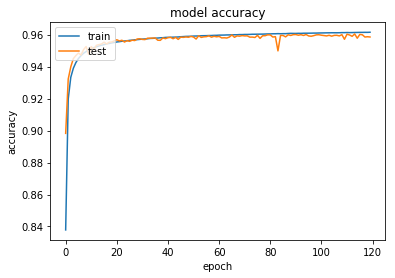

In [309]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

#labeling
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout

<function matplotlib.pyplot.tight_layout>

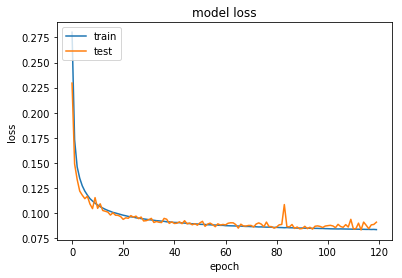

In [310]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

#labeling
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.tight_layout

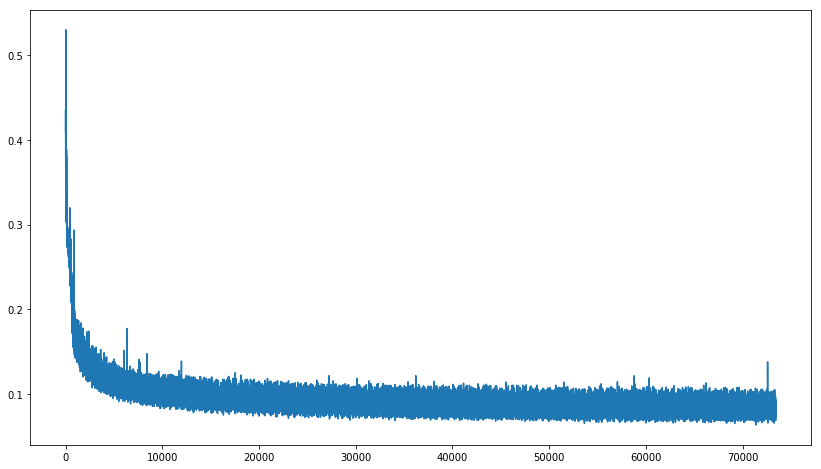

In [311]:
loss = hist.losses
Batches = range(len(loss)) 

fig = plt.figure(figsize=(14,8))
plt.plot(Batches, loss)
plt.show()

In [312]:
train_eval = UNet.evaluate_generator(data.batches(), steps = data.num_batches)
evalu      = UNet.evaluate_generator(data.val_batches(),steps = data.num_val_batches)

print(train_eval)
print(evalu)

[0.08627488565162506, 0.9622021313586266]
[0.09110612632664106, 0.9585067734463524]


#### save model

In [ ]:
# save model
benchmark_model_name = 'UNet.h5'
UNet.save(benchmark_model_name)

### Test Predictions

In [19]:
benchmark_model_name = 'UNet.h5'
# load model
from keras.models import load_model

UNet = load_model(benchmark_model_name)


In [20]:
x_batch, y_batch = next(data.val_batches())
y_prediction = UNet.predict_on_batch(x_batch)
UNet.test_on_batch(x_batch, y_batch)

[0.079500563, 0.96489906]

In [21]:
xx = DataSet(filepath,dataset_type='micro_2D', batch_size=32).reconstruct(y_batch)
yy = DataSet(filepath,dataset_type='micro_2D', batch_size=32).reconstruct(y_prediction)
#test_on_batch

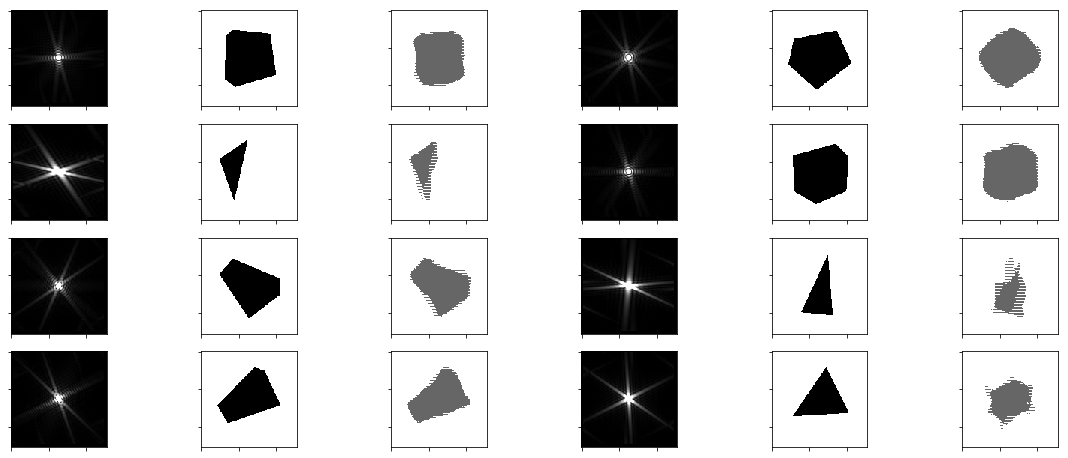

In [92]:
def ax_tick(ax1):
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    #ax1.set_aspect('equal')
    return None

#set picture size custom for paper
fig = plt.figure(1,figsize=(16,8))
max_num = 5
gs1 = gridspec.GridSpec(max_num, 6)
gs1.update(wspace=0.025, hspace=0.05)

for num in range(1,max_num):
    axs1 = plt.subplot2grid((max_num, 6), (num, 0) , rowspan=1, colspan=1)
    ax1 = plt.subplot2grid((max_num, 6), (num, 1) , rowspan=1, colspan=1)
    ax2 = plt.subplot2grid((max_num, 6), (num, 2) , rowspan=1, colspan=1)
    axs2 = plt.subplot2grid((max_num, 6), (num, 3) , rowspan=1, colspan=1)
    ax3 = plt.subplot2grid((max_num, 6), (num, 4) , rowspan=1, colspan=1)
    ax4 = plt.subplot2grid((max_num, 6), (num, 5) , rowspan=1, colspan=1)
    
    axs1.imshow(x_batch[num].reshape(128,128), cmap=plt.cm.gray_r)
    ax1.imshow(xx[num], cmap=plt.cm.gray)
    ax2.imshow(yy[num], cmap=plt.cm.gray, alpha=.6)
    axs2.imshow(x_batch[-num].reshape(128,128), cmap=plt.cm.gray_r)
    ax3.imshow(xx[-num], cmap=plt.cm.gray)
    ax4.imshow(yy[-num], cmap=plt.cm.gray, alpha=.6)
    
    ax_tick(axs1)
    ax_tick(axs2)
    ax_tick(ax1)
    ax_tick(ax2)
    ax_tick(ax3)
    ax_tick(ax4)
    

fig.subplots_adjust(wspace=0, hspace=0)

fig.tight_layout()
fig.savefig('results.pdf')
fig.show()

In [64]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

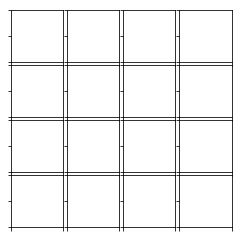

In [95]:
plt.figure(figsize = (4,4))
gs1 = gridspec.GridSpec(4, 4)
gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

for i in range(16):
    # grid spec indexes from 0
    ax1 = plt.subplot(gs1[i])
    plt.axis('on')
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    

plt.show()